In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import feather
import datetime
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgbm
# import optuna.integration.lightgbm as lgbm
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_Columns', 100)

In [2]:
train = pd.read_csv('../inputs/train.csv')
print(train.shape)
test = pd.read_csv('../inputs/test.csv')
print(test.shape)

(8359, 16)
(8360, 11)


In [3]:
def creansing(df_input):
    df_input['User_Score'] = df_input['User_Score'].replace({'nan': np.NaN, 'tbd': np.NaN}).astype(float)
    df_input['User_Score_int'] = df_input['User_Score'].round()
    df_input['Critic_Score_int'] = df_input['Critic_Score'].round(-1)/10
    df_input['User_Count_log'] = df_input['User_Count'].apply(np.log1p)

In [4]:
creansing(train)
creansing(test)

In [5]:
n_fold = 5

### label_encode

In [6]:
def get_non_overlapping(train: pd.DataFrame, test: pd.DataFrame, column: str):
    """train/testにしか出てこない値を調べる"""
    only_in_train = set(train[column].unique()) - set(test[column].unique())
    only_in_test = set(test[column].unique()) - set(train[column].unique())
    non_overlapping = only_in_train.union(only_in_test)
    return non_overlapping

def category2num(train: pd.DataFrame, test: pd.DataFrame, columns: list):
    train_ = train.copy()
    test_ = test.copy()
    for column in columns:
        non_overlapping = get_non_overlapping(train, test, column)
        try:
            if train[column].dtype == np.dtype("O"):
                # dtypeがobjectなら欠損は'missing' クラスにする
                train_[column] = train[column].fillna("missing")
                test_[column] = test[column].fillna("missing")
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else "other")
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else "other")
            else:
                # dtypeがint/floatなら欠損は'-1'とする
                train_[column] = train[column].fillna(-1)
                test_[column] = test[column].fillna(-1)
                train_[column] = train_[column].map(lambda x: x if x not in non_overlapping else -2)
                test_[column] = test_[column].map(lambda x: x if x not in non_overlapping else -2)

            le = preprocessing.LabelEncoder()
            concatenated = pd.concat([train_, test_], axis=0).reset_index(drop=True)
            le.fit(concatenated[column])
            train_[column] = le.transform(train_[column])
            test_[column] = le.transform(test_[column])
        except Exception:
            import pdb
            pdb.set_trace()
    return train_, test_

In [7]:
def create_label_encoding(df_train, df_test):
    tr, te = category2num(df_train, df_test, ['Platform', 'Genre', 'Developer', 'Rating'])
    return tr, te

### count_encode

In [8]:
def count_encoding(df_train, df_test, col):
    tr = df_train[col]
    te = df_test[col]
    whole = pd.concat([tr, te])
    vc = whole.value_counts(dropna=False)
    tr_ = pd.DataFrame(tr.map(vc)).add_prefix('CE_')
    te_ = pd.DataFrame(te.map(vc)).add_prefix('CE_')
    return tr_, te_

def create_count_encoding_feature(df_train, df_test):
    tr = pd.DataFrame()
    te = pd.DataFrame()
    for col in ['Platform', 'Genre', 'Publisher', 'Developer', 'Rating', 'User_Score_int', 'Critic_Score_int']:
        tr_, te_ = count_encoding(df_train, df_test, col)
        tr = pd.concat([tr, tr_], axis=1)
        te = pd.concat([te, te_], axis=1)
    return tr, te

### target_encode

In [9]:
def target_encoding(src, dst, group_col, target_col):
    agg_dict = {}
    for tc in target_col:
        agg_dict[tc] = 'mean'
    target = src.groupby(group_col).agg(agg_dict).reset_index()
    
    merge = pd.merge(dst[group_col], target, on=group_col, how='left').set_index(dst.index)
    suffix = '_'.join(group_col)
    return merge.drop(columns=group_col).add_prefix('TGE_').add_suffix('_mean_by_{}'.format(suffix))

In [10]:
def crete_target_enc_train_test(df_train, df_test, group_col, target_col):
    target = pd.DataFrame()
    kf = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    for train_index, eval_index in kf.split(df_train):
        kf_train = df_train.iloc[train_index]
        kf_eval = df_train.iloc[eval_index]
        tmp = target_encoding(kf_train, kf_eval, group_col, target_col)
        target = pd.concat([target, tmp])
    # train
    tr = target.sort_index()
    # test
    te = target_encoding(df_train, df_test, group_col, target_col)
    return tr, te

In [11]:
def create_target_encoding(df_train, df_test):
    tr = pd.DataFrame()
    te = pd.DataFrame()
    target1 = ['Global_Sales', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales']
    
    group1 = ['Platform']
    tr_, te_ = crete_target_enc_train_test(df_train, df_test, group1, target1)
    tr = pd.concat([tr, tr_], axis=1)
    te = pd.concat([te, te_], axis=1)
    
    group2 = ['Genre']
    tr_, te_ = crete_target_enc_train_test(df_train, df_test, group2, target1)
    tr = pd.concat([tr, tr_], axis=1)
    te = pd.concat([te, te_], axis=1)
    
    group3 = ['Rating']
    tr_, te_ = crete_target_enc_train_test(df_train, df_test, group3, target1)
    tr = pd.concat([tr, tr_], axis=1)
    te = pd.concat([te, te_], axis=1)
    
    group4 = ['User_Score_int']
    tr_, te_ = crete_target_enc_train_test(df_train, df_test, group4, target1)
    tr = pd.concat([tr, tr_], axis=1)
    te = pd.concat([te, te_], axis=1)
    
    group5 = ['Critic_Score_int']
    tr_, te_ = crete_target_enc_train_test(df_train, df_test, group5, target1)
    tr = pd.concat([tr, tr_], axis=1)
    te = pd.concat([te, te_], axis=1)
    
    return tr, te

### word

In [12]:
def create_word_features(df_train, df_test):
    train_word = pd.read_feather('../inputs/train_word.f')
    test_word = pd.read_feather('../inputs/test_word.f')
    tr = train_word.drop(columns=['Name']).add_prefix('WD_').fillna(0)
    te = test_word.drop(columns=['Name']).add_prefix('WD_').fillna(0)
    return tr.astype(int), te.astype(int)

### 特徴量生成

In [13]:
def create_feature(train, test):
    train_cp = train.copy()
    test_cp = test.copy()
    
    # count enc
    tr, te = create_count_encoding_feature(train_cp, test_cp)
    train_cp = pd.concat([train_cp, tr], axis=1)
    test_cp = pd.concat([test_cp, te], axis=1)
    
    # target enc
    tr, te = create_target_encoding(train_cp, test_cp)
    train_cp = pd.concat([train_cp, tr], axis=1)
    test_cp = pd.concat([test_cp, te], axis=1)
    
    # label enc
    train_cp, test_cp = create_label_encoding(train_cp, test_cp)
    
    # word
    tr, te = create_word_features(train_cp, test_cp)
    train_cp = pd.concat([train_cp, tr], axis=1)
    test_cp = pd.concat([test_cp, te], axis=1)
    
    print('train', train_cp.shape)
    print('test', test_cp.shape)
    assert len(train) == len(train_cp)
    assert len(test) == len(test_cp)
    return train_cp, test_cp

In [14]:
train_, test_ = create_feature(train, test)

train (8359, 2500)
test (8360, 2495)


In [15]:
train_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_int,Critic_Score_int,User_Count_log,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_NA_Sales_mean_by_Platform,TGE_EU_Sales_mean_by_Platform,TGE_JP_Sales_mean_by_Platform,TGE_Other_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_NA_Sales_mean_by_Genre,TGE_EU_Sales_mean_by_Genre,TGE_JP_Sales_mean_by_Genre,TGE_Other_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_NA_Sales_mean_by_Rating,TGE_EU_Sales_mean_by_Rating,TGE_JP_Sales_mean_by_Rating,TGE_Other_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_NA_Sales_mean_by_User_Score_int,TGE_EU_Sales_mean_by_User_Score_int,TGE_JP_Sales_mean_by_User_Score_int,TGE_Other_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_NA_Sales_mean_by_Critic_Score_int,TGE_EU_Sales_mean_by_Critic_Score_int,TGE_JP_Sales_mean_by_Critic_Score_int,...,WD_blacklist,WD_austria,WD_scorpion,WD_stafi,WD_reading,WD_declassified,WD_blaster,WD_reader,WD_yoshimune,WD_dynamite,WD_score,WD_mischief,WD_langrisser,WD_iris,WD_jane,WD_spelling,WD_blowhole,WD_definitive,WD_wedding,WD_spanish,WD_minority,WD_minutes,WD_start,WD_inuyasha,WD_itadaki,WD_living,WD_leisure,WD_lemony,WD_lelouch,WD_renka,WD_azure,WD_seishun,WD_metallica,WD_starsky,WD_sorcery,WD_sprint,WD_jewels,WD_edventures,WD_jigoku,WD_jiken,WD_remember,WD_issho,WD_remington,WD_saturdays,WD_john,WD_echo,WD_metabee,WD_axis,WD_michi,WD_croods
0,LEGO Batman: The Videogame,23,NaN,0,Warner Bros. Interactive Entertainment,180,97,0,28,306,74.0,17.0,7.9,22.0,425,1,8.0,7.0,3.135494,1320,3370,235,77,1420,2830,2019,93.604962,49.872137,27.200382,8.368321,8.145038,61.883755,31.386282,17.989892,5.475812,6.987004,49.257785,25.621107,13.562284,4.332180,5.737024,106.536082,51.999141,32.794674,10.611684,11.088488,49.231678,24.938534,14.355792,4.789598,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,LEGO Indiana Jones: The Original Adventures,23,NaN,0,LucasArts,151,61,0,21,234,78.0,22.0,6.6,28.0,425,1,7.0,8.0,3.367296,1320,3370,90,77,1420,1634,2366,96.597250,50.809430,28.023576,9.306483,8.412574,58.394680,29.987060,16.765636,5.948239,5.648454,49.148789,25.124567,13.576125,4.896194,5.579585,66.403374,32.015337,20.190184,7.177914,6.976994,101.466970,48.555809,30.006834,12.998861,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,LEGO Batman: The Videogame,17,NaN,0,Warner Bros. Interactive Entertainment,56,44,0,27,128,73.0,5.0,7.4,10.0,425,1,7.0,7.0,2.397895,1209,3370,235,77,1420,1634,2019,29.606403,11.022599,6.994350,7.145009,4.410546,59.681720,30.205018,16.948387,5.839427,6.645878,53.568595,27.580165,14.771901,5.320661,5.904132,64.981846,32.322239,19.475038,6.487141,6.656581,46.931655,23.537170,13.357314,5.376499,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Combat,0,NaN,0,Atari,117,7,0,1,125,NaN,NaN,NaN,NaN,467,6,NaN,NaN,NaN,133,3370,367,6623,6769,9129,8582,65.943662,61.563380,3.704225,0.000000,0.577465,62.435252,31.738849,17.913669,5.722302,7.015108,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,LEGO Harry Potter: Years 5-7,23,NaN,0,Warner Bros. Interactive Entertainment,69,42,0,12,124,76.0,8.0,7.8,13.0,425,1,8.0,8.0,2.639057,1320,3370,235,77,1420,2830,2366,96.597250,50.809430,28.023576,9.306483,8.412574,58.394680,29.987060,16.765636,5.948239,5.648454,49.148789,25.124567,13.576125,4.896194,5.579585,99.656627,48.981928,29.567986,10.444062,10.611876,101.466970,48.555809,30.006834,12.998861,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [16]:
test_.head()

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,User_Score_int,Critic_Score_int,User_Count_log,CE_Platform,CE_Genre,CE_Publisher,CE_Developer,CE_Rating,CE_User_Score_int,CE_Critic_Score_int,TGE_Global_Sales_mean_by_Platform,TGE_NA_Sales_mean_by_Platform,TGE_EU_Sales_mean_by_Platform,TGE_JP_Sales_mean_by_Platform,TGE_Other_Sales_mean_by_Platform,TGE_Global_Sales_mean_by_Genre,TGE_NA_Sales_mean_by_Genre,TGE_EU_Sales_mean_by_Genre,TGE_JP_Sales_mean_by_Genre,TGE_Other_Sales_mean_by_Genre,TGE_Global_Sales_mean_by_Rating,TGE_NA_Sales_mean_by_Rating,TGE_EU_Sales_mean_by_Rating,TGE_JP_Sales_mean_by_Rating,TGE_Other_Sales_mean_by_Rating,TGE_Global_Sales_mean_by_User_Score_int,TGE_NA_Sales_mean_by_User_Score_int,TGE_EU_Sales_mean_by_User_Score_int,TGE_JP_Sales_mean_by_User_Score_int,TGE_Other_Sales_mean_by_User_Score_int,TGE_Global_Sales_mean_by_Critic_Score_int,TGE_NA_Sales_mean_by_Critic_Score_int,TGE_EU_Sales_mean_by_Critic_Score_int,TGE_JP_Sales_mean_by_Critic_Score_int,TGE_Other_Sales_mean_by_Critic_Score_int,WD_world,WD_game,WD_super,WD_star,...,WD_blacklist,WD_austria,WD_scorpion,WD_stafi,WD_reading,WD_declassified,WD_blaster,WD_reader,WD_yoshimune,WD_dynamite,WD_score,WD_mischief,WD_langrisser,WD_iris,WD_jane,WD_spelling,WD_blowhole,WD_definitive,WD_wedding,WD_spanish,WD_minority,WD_minutes,WD_start,WD_inuyasha,WD_itadaki,WD_living,WD_leisure,WD_lemony,WD_lelouch,WD_renka,WD_azure,WD_seishun,WD_metallica,WD_starsky,WD_sorcery,WD_sprint,WD_jewels,WD_edventures,WD_jigoku,WD_jiken,WD_remember,WD_issho,WD_remington,WD_saturdays,WD_john,WD_echo,WD_metabee,WD_axis,WD_michi,WD_croods
0,Hitman 2: Silent Assassin,26,NaN,0,Eidos Interactive,84.0,23.0,8.0,19.0,216,3,8.0,8.0,2.995732,824,3370,198,20,1563,2830,2366,28.428571,20.981132,6.150943,0.342318,0.854447,61.011474,30.986804,17.488812,5.831899,6.660929,96.410622,49.340674,30.253886,4.761658,12.018135,100.864791,49.389842,30.273850,10.341798,10.817433,99.177204,47.279608,29.327694,12.945681,9.588602,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Legacy of Kain: Soul Reaver,13,NaN,0,Eidos Interactive,91.0,17.0,9.0,132.0,112,5,9.0,9.0,4.890349,1197,3370,198,25,2961,1033,760,72.632812,31.730469,19.365234,17.726562,3.820312,61.011474,30.986804,17.488812,5.831899,6.660929,50.841880,24.622507,12.972222,7.970085,5.212963,126.789762,60.824497,30.553931,23.835466,11.555759,201.134986,98.074380,54.297521,27.977961,20.713499,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Metal Gear Solid 2: Substance,26,NaN,0,Konami Digital Entertainment,87.0,28.0,8.5,39.0,469,3,8.0,9.0,3.688879,824,3370,834,12,1563,2830,760,28.428571,20.981132,6.150943,0.342318,0.854447,61.011474,30.986804,17.488812,5.831899,6.660929,96.410622,49.340674,30.253886,4.761658,12.018135,100.864791,49.389842,30.273850,10.341798,10.817433,201.134986,98.074380,54.297521,27.977961,20.713499,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Silent Hill: Homecoming,25,NaN,0,Konami Digital Entertainment,70.0,54.0,6.9,180.0,134,3,7.0,7.0,5.198497,1262,3370,834,22,1563,1634,2019,81.399660,50.506803,22.384354,1.324830,7.168367,61.011474,30.986804,17.488812,5.831899,6.660929,96.410622,49.340674,30.253886,4.761658,12.018135,66.212871,32.352723,20.110149,6.769802,6.935644,48.703390,24.525424,13.989642,5.258004,4.897363,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Silent Hill: Homecoming,15,NaN,0,Konami Digital Entertainment,71.0,41.0,6.9,143.0,134,3,7.0,7.0,4.969813,1331,3370,834,22,1563,1634,2019,71.405910,30.816485,23.763608,6.589425,10.216174,61.011474,30.986804,17.488812,5.831899,6.660929,96.410622,49.340674,30.253886,4.761658,12.018135,66.212871,32.352723,20.110149,6.769802,6.935644,48.703390,24.525424,13.989642,5.258

In [17]:
lgbm_param = {
    'objective' : 'regression',
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'seed' : 0,
    'learning_rate':  0.1,
    
    'max_depth': 6,
    'n_estimators': 10000,
    'colsample_bytree': 0.5,
    'importance_type': 'gain'
}

In [18]:
def train_lgbm(X, y, group, params: dict, verbose=100):

    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = list(fold.split(X)) 
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        x_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
        x_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=verbose)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[idx_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [19]:
def train_lgbm_group(X, y, group, params: dict, verbose=100):

    unique_group = group.unique()
    fold = KFold(n_splits=n_fold, shuffle=True, random_state=0)
    cv = fold.split(unique_group)
    
    models = []
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (tr_group_idx, va_group_idx) in enumerate(cv):
        
        train_groups = unique_group[tr_group_idx]
        valid_groups = unique_group[va_group_idx]
        is_train = group.isin(train_groups)
        is_valid = group.isin(valid_groups)
        
        x_train, y_train = X[is_train], y[is_train]
        x_valid, y_valid = X[is_valid], y[is_valid]
        print('x_train', x_train.shape)
        print('x_valid', x_valid.shape)
        
        lgbm_train = lgbm.Dataset(x_train, y_train)
        lgbm_eval = lgbm.Dataset(x_valid, y_valid, reference=lgbm_train)
        
        lgbm_model = lgbm.train(params, 
                                                    lgbm_train, 
                                                    valid_sets=lgbm_eval,
                                                    num_boost_round=10000,
                                                    early_stopping_rounds=verbose,
                                                    verbose_eval=verbose)
        y_pred = lgbm_model.predict(x_valid, num_iteration=lgbm_model.best_iteration)
        
        oof_pred[is_valid] = y_pred
        models.append(lgbm_model)
        print('Fold {} Score: {:.4f}'.format(i, np.sqrt(mean_squared_error(y_valid, y_pred))))

    score = np.sqrt(mean_squared_error(y, oof_pred))
    print('FINISHED \ whole score: {:.4f}'.format(score))
    return oof_pred, models, score

In [20]:
def train_pred(train_df, y, test_df, group):
    oof, models, score = train_lgbm_group(train_df, y, group, lgbm_param)
    
    pred_list = []
    for model in models:
            pred = model.predict(test_df, num_iteration = model.best_iteration)
            pred = np.expm1(pred)
            pred_list.append(pred)
            print(pred.mean())
            
    pred = np.mean(pred_list, axis=0)
    return pred, score, models

In [21]:
def feat_imp(model):
    fi = model.feature_importance()
    fn = model.feature_name()
    df_feature_importance = pd.DataFrame({'name':fn, 'imp':fi})
    df_feature_importance.sort_values('imp', inplace=True)
    return df_feature_importance

def feature_importance(models):
    fi = pd.DataFrame(columns=['name'])
    for i, model in enumerate(models):
        fi_tmp = feat_imp(model)
        colname = 'imp_{}'.format(i)
        fi_tmp.rename(columns={'imp': colname}, inplace=True)
        fi = pd.merge(fi, fi_tmp, on=['name'], how='outer')
    fi['sum'] = fi.sum(axis=1)
    return fi.sort_values(['sum'], ascending=False)

In [22]:
%%time
y = train_['Global_Sales'].apply(np.log1p)
group = train_['Publisher'].copy()
train_.drop(columns=['Name', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales'], inplace=True)
test_.drop(columns=['Name', 'Publisher',], inplace=True)
column_cnt = len(train_.columns)
assert train_.shape[1] == test_.shape[1]

pred, score, models = train_pred(train_, y, test_, group)

x_train (6174, 2493)
x_valid (2185, 2493)


/Users/umeharayasunobu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 1.21517
Early stopping, best iteration is:
[75]	valid_0's rmse: 1.21377
Fold 0 Score: 1.2138
x_train (7540, 2493)
x_valid (819, 2493)


/Users/umeharayasunobu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.9254
[200]	valid_0's rmse: 0.927901
Early stopping, best iteration is:
[110]	valid_0's rmse: 0.923794
Fold 1 Score: 0.9238
x_train (5807, 2493)
x_valid (2552, 2493)


/Users/umeharayasunobu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.977784
[200]	valid_0's rmse: 0.974835
Early stopping, best iteration is:
[177]	valid_0's rmse: 0.971408
Fold 2 Score: 0.9714
x_train (6856, 2493)
x_valid (1503, 2493)


/Users/umeharayasunobu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.95705
[200]	valid_0's rmse: 0.950928
Early stopping, best iteration is:
[187]	valid_0's rmse: 0.949232
Fold 3 Score: 0.9492
x_train (7059, 2493)
x_valid (1300, 2493)


/Users/umeharayasunobu/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.9575
[200]	valid_0's rmse: 0.955601
[300]	valid_0's rmse: 0.948971
[400]	valid_0's rmse: 0.947606
Early stopping, best iteration is:
[398]	valid_0's rmse: 0.947402
Fold 4 Score: 0.9474
FINISHED \ whole score: 1.0288
27.180172232551207
31.587222069528885
29.998248471764455
33.33570351883878
34.13038370783844
CPU times: user 27.8 s, sys: 6.28 s, total: 34.1 s
Wall time: 19.4 s


In [23]:
feature_importance(models).head(50)

,name,imp_0,imp_1,imp_2,imp_3,imp_4,sum
2491,Year_of_Release,135,192,211,203,389,1130
2492,CE_Publisher,175,144,183,181,376,1059
2489,User_Count,89,83,130,124,203,629
2490,TGE_JP_Sales_mean_by_Platform,90,69,98,103,195,555
2488,CE_Platform,71,69,83,115,145,483
2487,TGE_Global_Sales_mean_by_Platform,65,62,89,85,160,461
2486,CE_Developer,62,56,73,76,154,421
2482,TGE_JP_Sales_mean_by_Genre,47,50,76,92,142,407
2477,TGE_NA_Sales_mean_by_Platform,33,45,66,92,165,401
2483,TGE_Other_Sales_mean_by_Platform,47,31,66,79,173,396


In [24]:
df_pred = pd.DataFrame(pred, columns=['Global_Sales'])
df_pred.loc[df_pred['Global_Sales'] < 1, 'Global_Sales'] = 0
print(df_pred.shape)
pred_mean = df_pred['Global_Sales'].mean()
pred_max = df_pred['Global_Sales'].max()
print('mean=', pred_mean)
print('max=', pred_max)
assert len(df_pred) == len(test)

(8360, 1)
mean= 31.246346000104346
max= 569.0352481207419


Text(0.5, 0, 'Global_Sales')

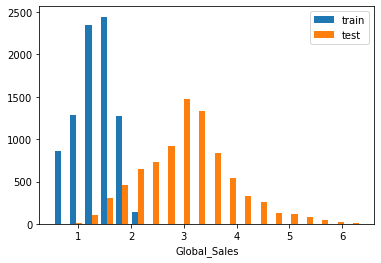

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist([np.log1p(y), np.log1p(df_pred['Global_Sales'])], bins=20, label=['train', 'test'])
ax.legend()
ax.set_xlabel('Global_Sales')

In [26]:
FILENAME = 'submission.csv'
OUTPUT_DIR = '../outputs/'
filepath = os.path.join(OUTPUT_DIR, FILENAME)
df_pred.to_csv(filepath, index=False)
print(filepath)

../outputs/submission.csv


In [27]:
print('- feat =', column_cnt)
print('- mean = {:.4f}'.format(pred_mean))
print('- max = {:.4f}'.format(pred_max))
print('- score = {:.4f}'.format(score))

- feat = 2493
- mean = 31.2463
- max = 569.0352
- score = 1.0288


#### 4-1: hyper-param
- feat = 2493
- mean = 31.2463
- max = 569.0352
- score = 1.0288
- LB= 0.9343

#### 4: groupKfold
- feat = 2493
- mean = 31.4331
- max = 586.5045
- score = 1.0276
- LB= 0.9369

#### 3: word
- feat = 2493
- mean = 31.4031
- max = 719.7462
- score = 0.8767
- LB= 0.9438

#### 2: target_enc
- feat = 31
- mean = 33.8397
- max = 954.7167
- score = 0.9164
- LB= 0.9535

#### 1: first
- feat = 16
- mean = 35.8113
- max = 955.3011
- score = 0.9007
- LB= 0.9763